# Initial tests with Elvis

Okay Here I want to make three plots

1) subhalos as a function of distance for all halos above V_max = 10 km/s compared to galaxies above 10^5 in stellar mass

2) subhalos Vmax > 8 and galaxies greater than 10^4 but in angles simulating SDSS and DES

3) subhalos Vmax > 5 and galaxies > 10^3 but for angles simulating SDSS and DES



In [1]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [104]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sys, os, re

from andrew_tools.simple_tools import high_low_limit

In [4]:
# test with one halo

#for the isolated files this is just the rockstar files (sort of)
#1,2,3 are X,Y, and Z in Mpc
#4,5,6 are Vx, Vy, and Vz
#7 is Vmax
#8 is Vpeak
#9 is Mvir
#10 is Mpeak
#11 is Rvir in kpc
#first column is host

f = np.loadtxt('./ELVIS_Halo_Catalogs/IsolatedCatalogs/iBurr.txt')

X, Y, Z = f[:,1], f[:,2], f[:,3]
coords = np.zeros((len(X),3))
coords[:,0], coords[:,1], coords[:,2] = X,Y,Z
V_max = f[:,7]
V_peak = f[:,8]
R_vir = f[:,11]

#Host properties
X_host, Y_host, Z_host = f[:,1][0], f[:,2][0], f[:,3][0]
coords_host = coords[0]
V_max_host = f[:,7][0]
V_max_host = f[:,8][0]
R_vir_host = f[:,11][0]

coord_diff = coords-coords_host

dist = np.linalg.norm(coord_diff,axis=1)
print dist

large_subs_mask = (dist<R_vir_host/1000.0)&(dist>0.0)&(V_max>10.0)

large_subs_V_max = V_max[large_subs_mask]
large_subs_dist = dist[large_subs_mask]*1000.0


f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
print f_dat[:,1]
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e5)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
print large_gal_dist

[ 0.          0.31240248  0.35902053 ...,  1.51449063  1.54184045
  1.59343665]
['105' '76' '147' '254' '233' '51' '76' '64' '86' '86' '26' '66' '42' '218'
 '160' '44' '132' '154' '178' '417' '210' '80' '182' '23' '35' '97' '32'
 '38' '30' '182' '366' '95' '120' '53' '87' '78' '69' '214' '95' '126' '32'
 '92' '58' '25' '48' '55']
[ 105.   76.  147.  254.  233.   51.   76.   64.   86.   86.   26.  218.]


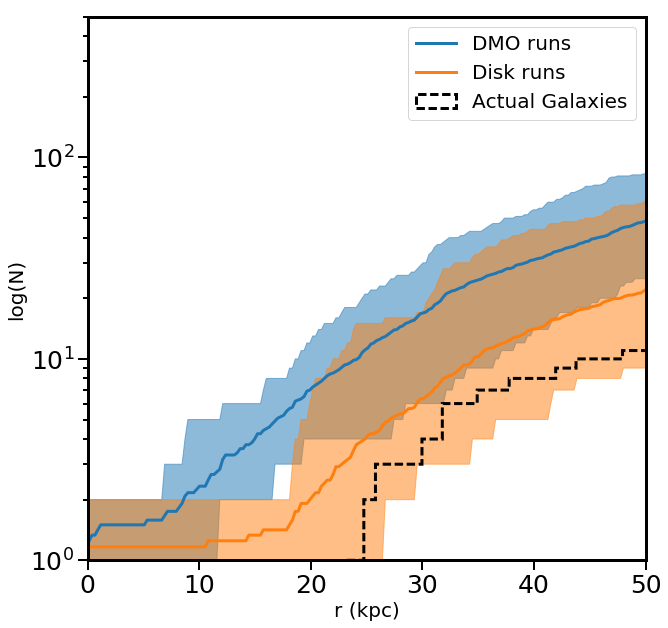

In [102]:

n_files = len(os.listdir('./Tyler_Data/'))

all_hist_matrix = np.zeros((n_files,1000)) 

n_iter = 0

for data_file in os.listdir('./Tyler_Data/'):
    f_halos = h5py.File('./Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

    Vmax_mask = (Data_M>8.0)

    Data_cens_cut = Data_cens[Vmax_mask]
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    host_cen = Data_cens_cut[host_index]
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    all_hist, all_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    all_hist_c = np.cumsum(all_hist)
    all_hist_matrix[n_iter] = all_hist_c
    n_iter += 1

disk_files = len(os.listdir('./Tyler_disk_data/'))

disk_hist_matrix = np.zeros((disk_files,1000)) 

disk_iter = 0
    
for data_file in os.listdir('./Tyler_disk_data/'):
    f_halos = np.loadtxt('./Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    disk_hist, disk_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,R_vir_host,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C1',label='Disk runs')

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

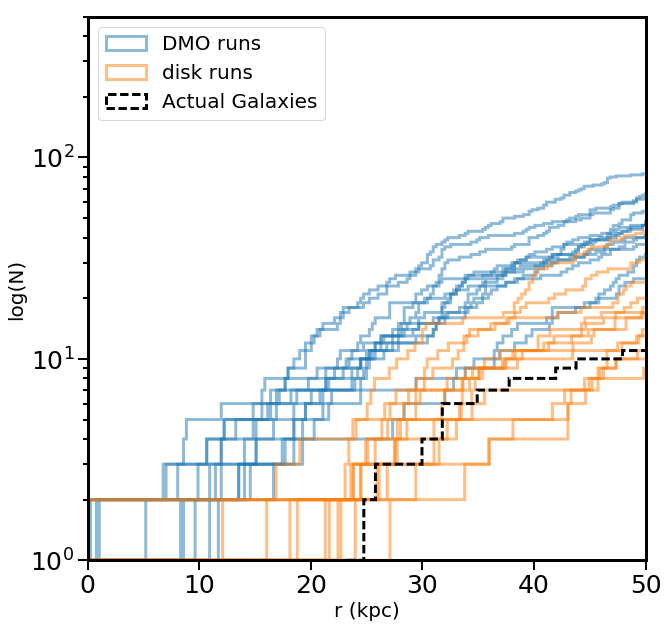

In [103]:
n_files = len(os.listdir('./Tyler_Data/'))

all_hist_matrix = np.zeros((n_files,1000)) 

n_iter = 0

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

for data_file in os.listdir('./Tyler_Data/'):
    f_halos = h5py.File('./Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

    Vmax_mask = (Data_M>8.0)

    Data_cens_cut = Data_cens[Vmax_mask]
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    host_cen = Data_cens_cut[host_index]
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    all_hist, all_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    
    plt.hist(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001),cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C0')
    
    all_hist_c = np.cumsum(all_hist)
    all_hist_matrix[n_iter] = all_hist_c
    n_iter += 1

disk_files = len(os.listdir('./Tyler_disk_data/'))

disk_hist_matrix = np.zeros((disk_files,1000)) 

disk_iter = 0
    
for data_file in os.listdir('./Tyler_disk_data/'):
    f_halos = np.loadtxt('./Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])
    
    #print Data_cens_cut
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    disk_hist, disk_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    plt.hist(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001),cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C1')
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,R_vir_host,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

plt.hist([],cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C0',label='DMO runs')
plt.hist([],cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C1',label='disk runs')
plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.legend(loc=2, prop={'size': 20})
plt.savefig('./initial_figures/all_halos_individual.png',bbox_inches='tight')
plt.show()

1107
159.688538
242551 3982
what
493


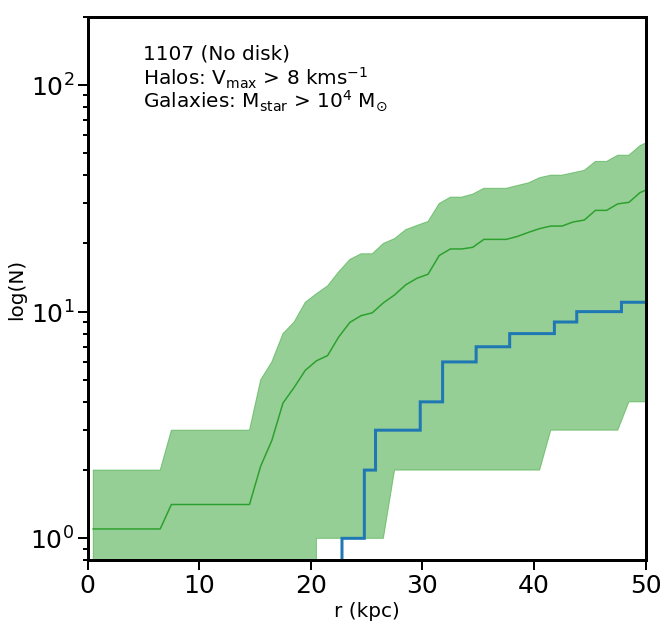

1245
146.530869
104482 1819
what
625


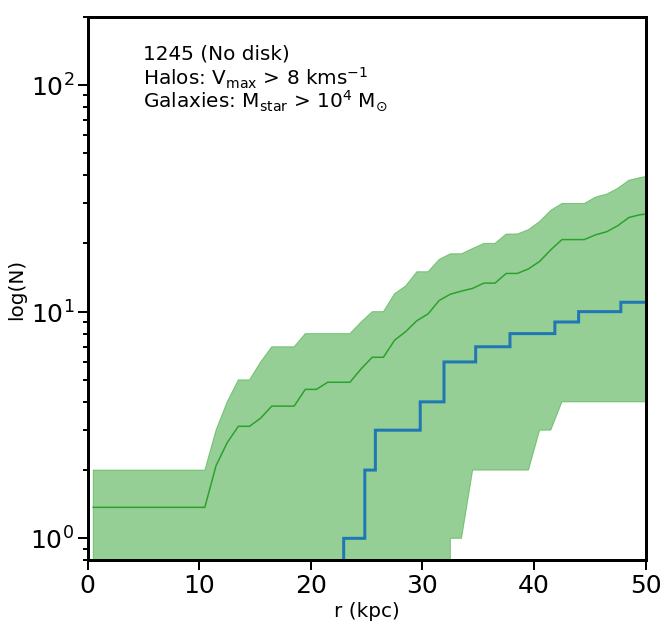

1386
140.019745
118960 1843
what
1309


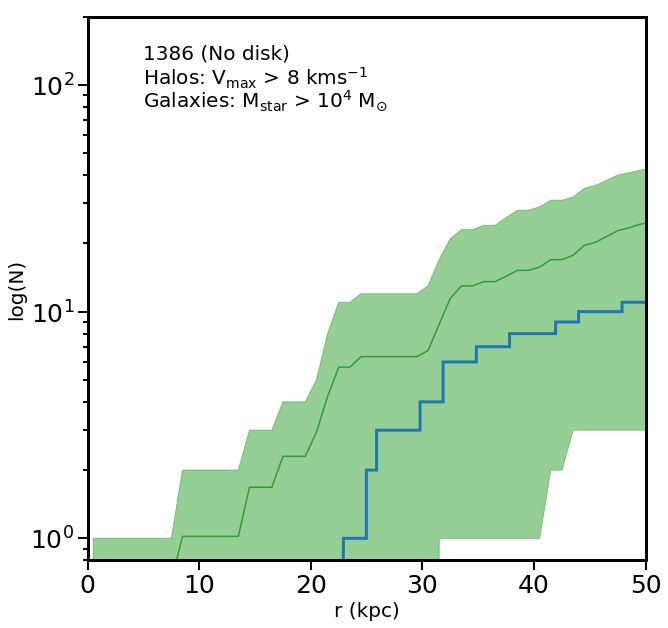

493
192.378357
185200 3172
what
2287


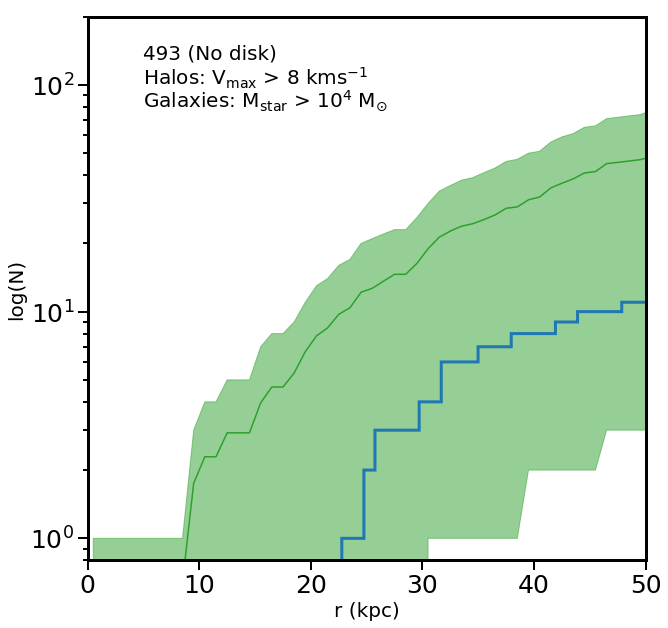

539
195.584503
175786 2836
what
572


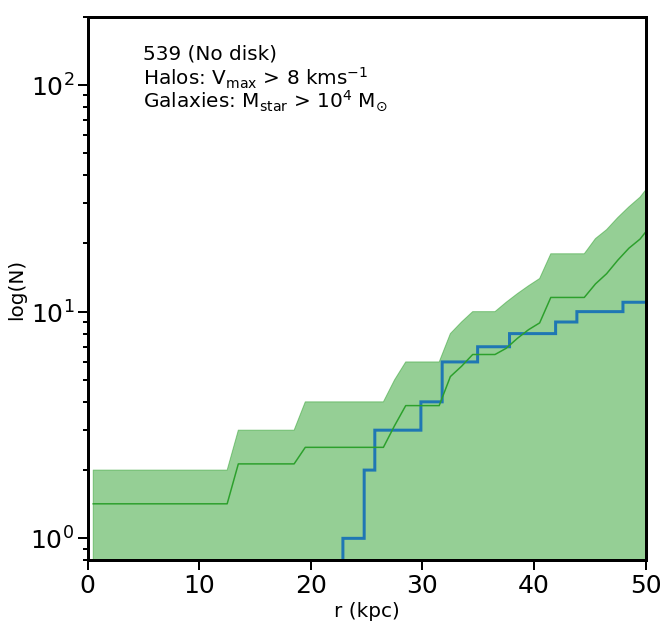

609
182.594086
199692 3258
what
2491


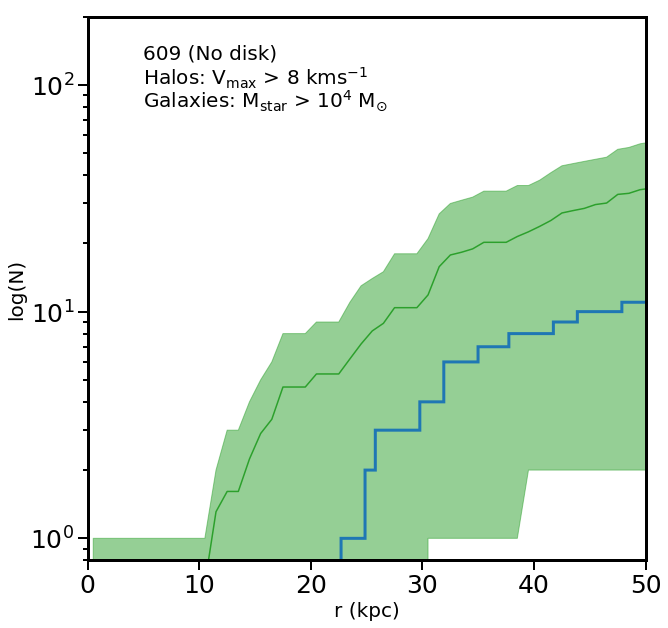

694
175.10144
234487 3719
what
2713


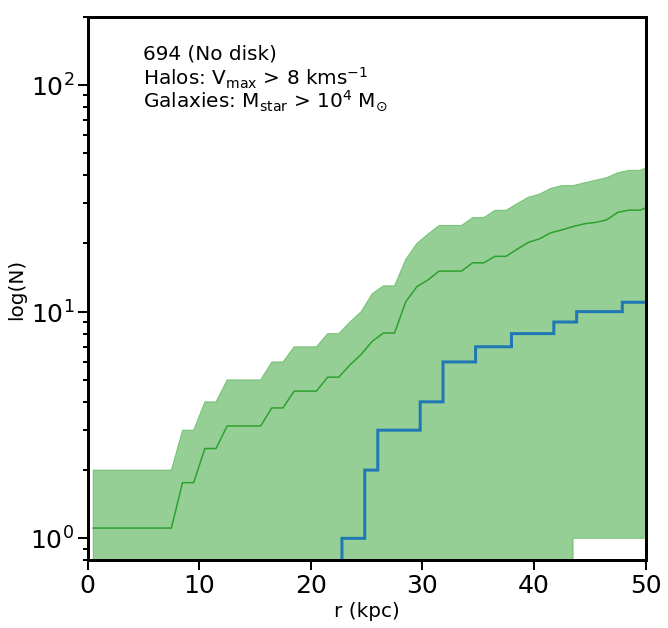

795
170.010773
158501 2485
what
2125


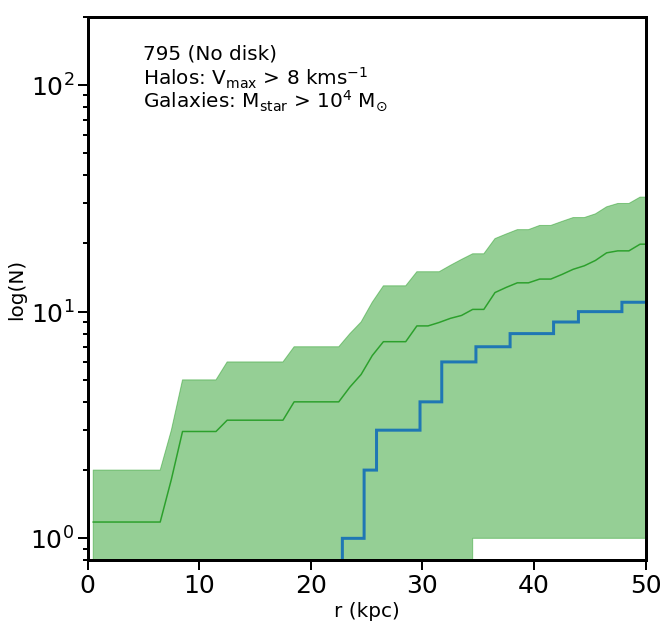

833
157.829819
164499 2764
what
183


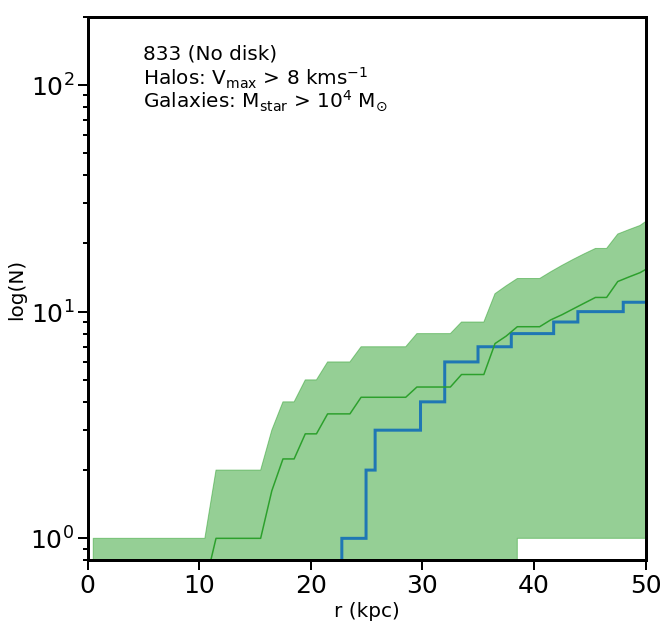

848
183.40329
132488 2026
what
404


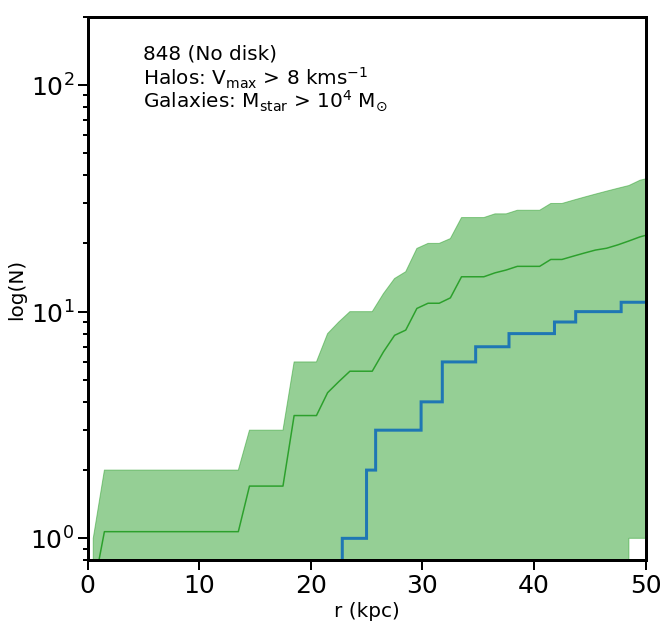

879
159.268616
140356 2086
what
1200


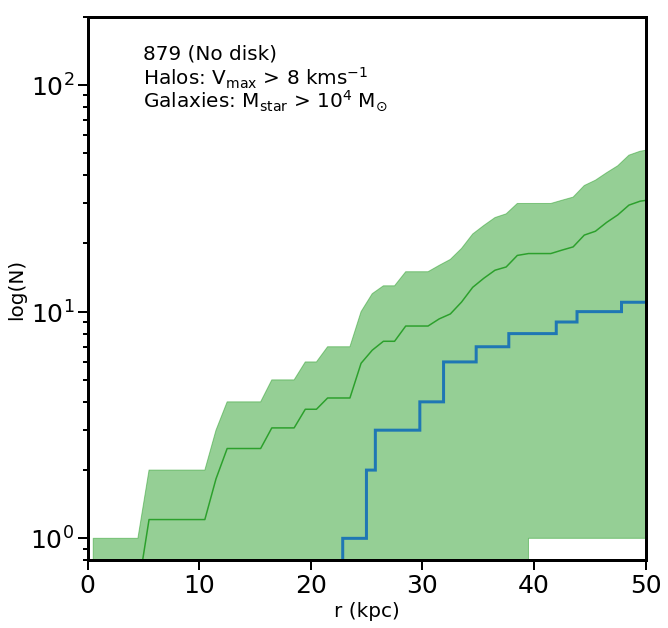

988
152.162292
110190 1797
what
106


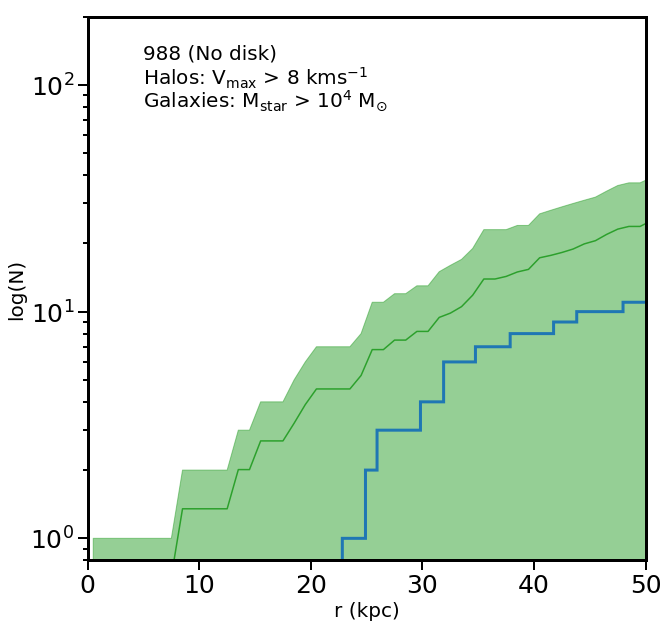

In [113]:
#Here I'm going to put Claire's module

pnts = 100

DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

DES_cone_size = 0.7259
SDSS_coneS_size = 0.7259  #t2
SDSS_coneB_size = 0.9929   #t3

#corr_factors = np.zeros((len(data_files),pnts))
#count_mas = np.zeros((len(data_files),pnts))

radius_bins = np.linspace(0.0,0.1,101)

h = 0.6751

def cart2sph(x,y,z):
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def calc_open_angle(phi_x,the_x,phi_t,the_t):
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr):
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    RO2 = 0.0
    

    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    print 'what'
    print MW
    pair_dist = z0_cens[Andr] - z0_cens[MW]   # First two are the hosts (M31 & MW)
    coord_dist = z0_cens[2:] - z0_cens[MW]
    
    dis_g = np.linalg.norm(pair_dist)
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[newaxis]
    
    angle_BG = np.arctan(RO2/dis_g)
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])
    _, phi_t, the_t = cart2sph(-pair_dist[0],-pair_dist[1],-pair_dist[2])

    ang_dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    Andr_gal = ang_dis <= angle_BG # Mask things that are in the same area as Andr.
    Andr_gal = Andr_gal[np.newaxis].T & np.ones(pnts,dtype = 'bool') # Make into N x pnts matrix

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts)) & (~Andr_gal)

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS

    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    for ii in range(len(stacked_distance_array_fast[0])):
        #pull out each individual mask
        indiv_mask = in_cones[:,ii]
        #pull out each of the distance arrays (note: I could just use the distances as in always using the
        #distances_from_center array, but I matricized it in case I ever figure out how to do this without
        #a loop)
        indiv_dist = stacked_distance_array_fast[:,ii]
        
        halos_within_cone = indiv_dist[indiv_mask]
        
        #now lets bin it with a histogram
        
        hist, bins = np.histogram(halos_within_cone,bins=radius_bins)
        histogram_matrix[ii] = np.cumsum(hist)
    
    #print len(masking_test)
    #print len(stacked_distance_array_fast[:,0][in_cones[:,0]])
    
    count_mas = np.sum(in_cones[Data_M[2:] >= M_t], axis = 0 ) * 1.
    count_tot = np.sum(r_msk[Data_M[2:] >= M_t], axis = 0 ) * 1.
    
    #print shape(in_cones)
    #print shape(stacked_distance_array_fast)
    #print shape(distances_within_cones)
    
    return histogram_matrix

'''for file_name in xrange(len(data_files)):
    # file.write(" NEW " + file_name+' ')
    if use_vmax:
        Data_M = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt')[:,0]
    else:
        Data_M = np.amax(np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt'),axis=1)
    Data_X = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/X.txt')[:,0]
    Data_Y = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Y.txt')[:,0]
    Data_Z = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Z.txt')[:,0]
    Data_Rvir = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Rvir.txt')[:,0]

    corr_factors[file_name],count_mas[file_name] = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)
'''

for data_file in os.listdir('./Tyler_Data/'):
    f_halos = h5py.File('./Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    print Data_M_cut[host_index]
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index
    
    print len(Data_X), len(Data_X_cut) 

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.mean(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')
    
    plt.text(5.0,130.0,halo_name+' (No disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,min_line,max_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.legend(loc=1, prop={'size': 20})
    plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'.png',bbox_inches='tight')
    plt.show()

1107
159.688538
242551 17944


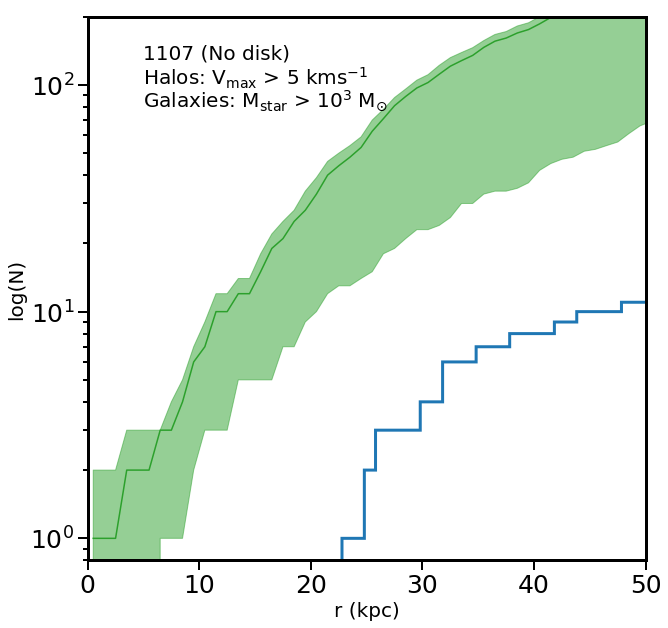

1245
146.530869
104482 8827


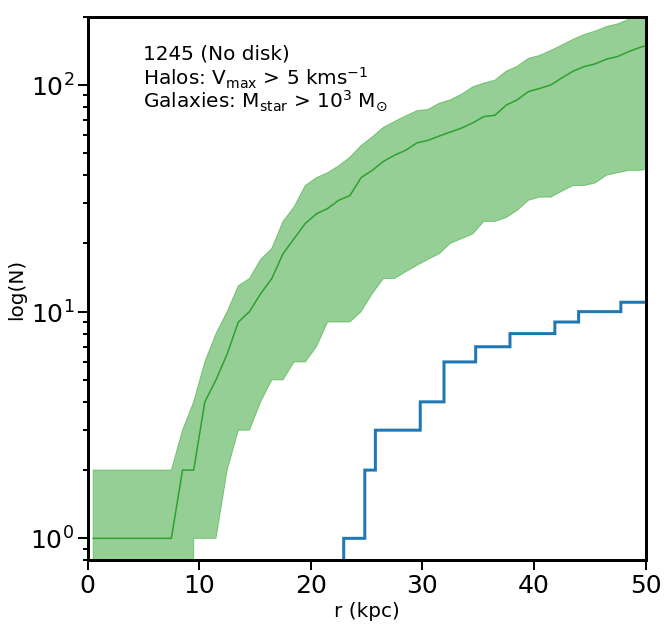

1386
140.019745
118960 8756


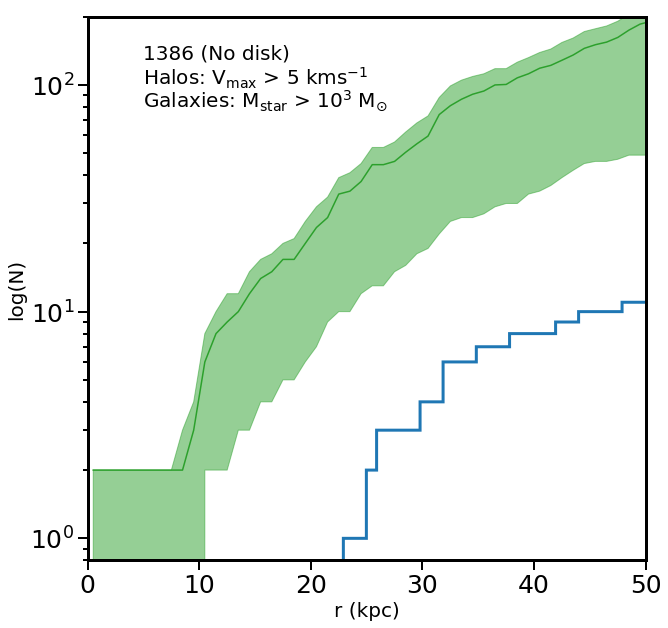

493
192.378357
185200 15349


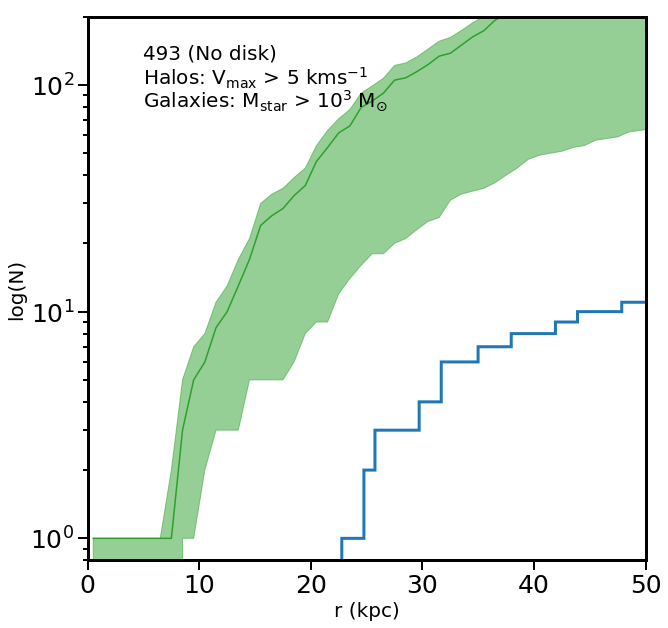

539
195.584503
175786 13191


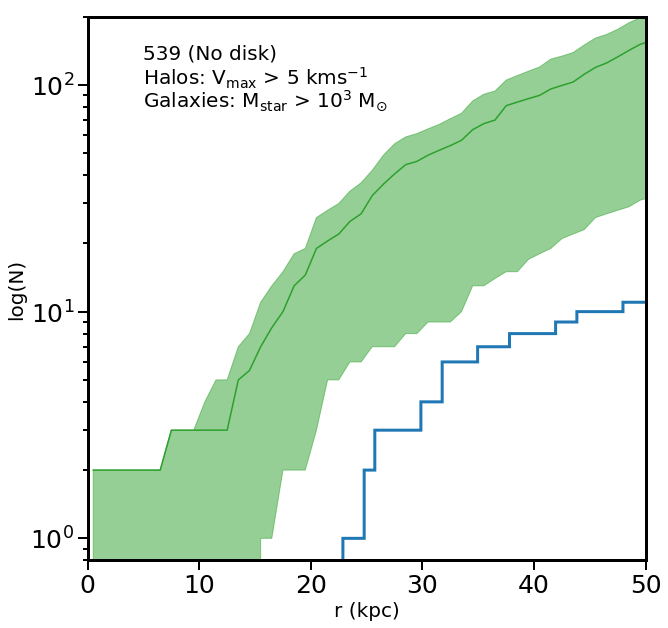

609
182.594086
199692 15478


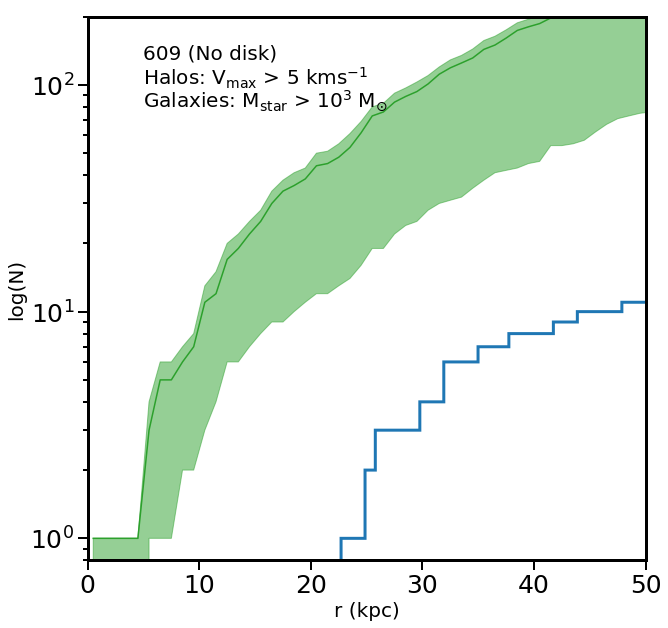

694
175.10144
234487 16770


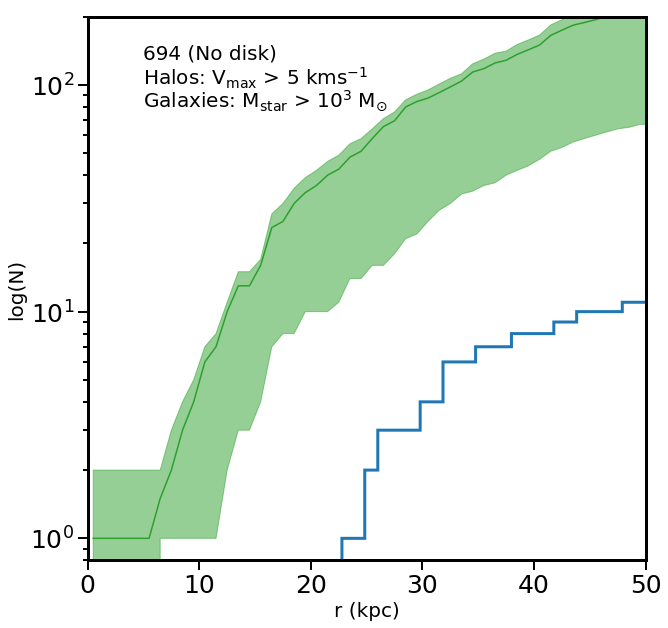

795
170.010773
158501 11660


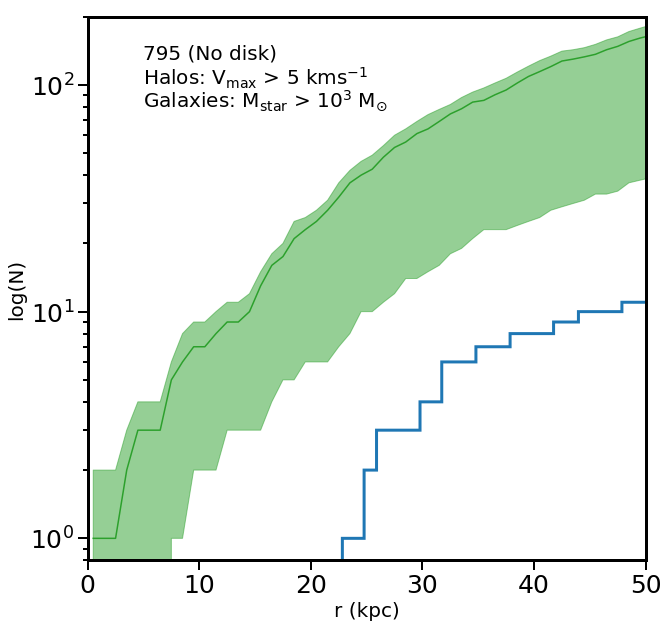

833
157.829819
164499 12712


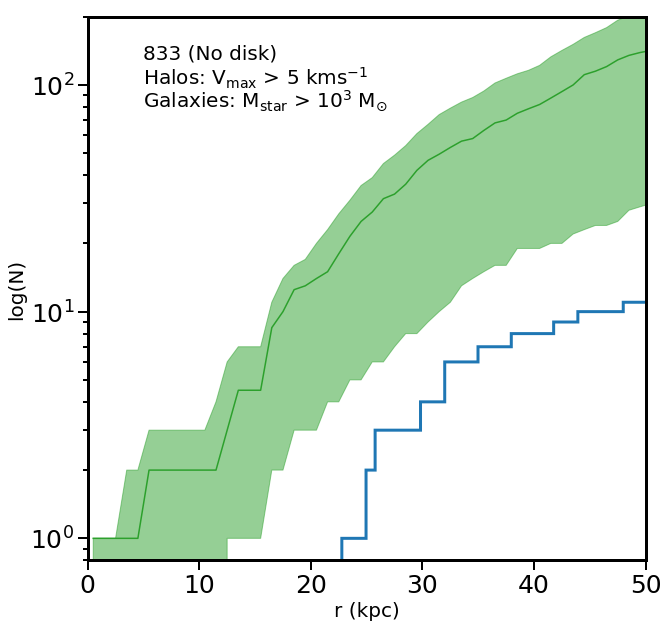

848
183.40329
132488 9591


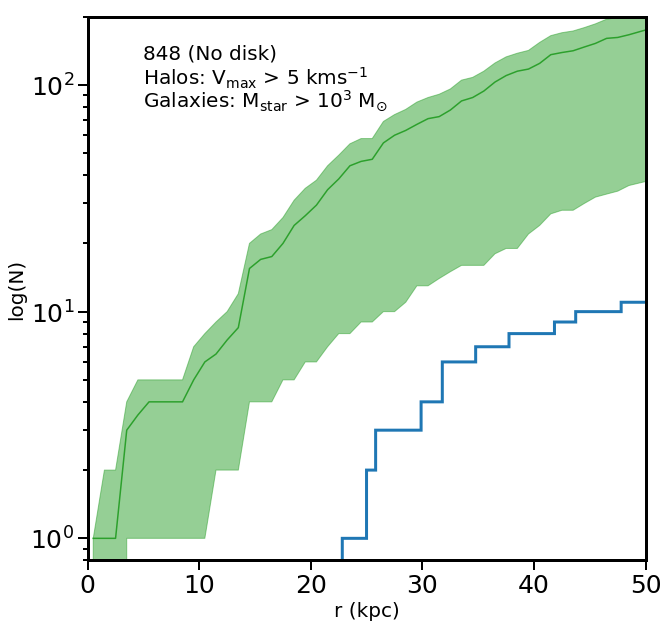

879
159.268616
140356 9830


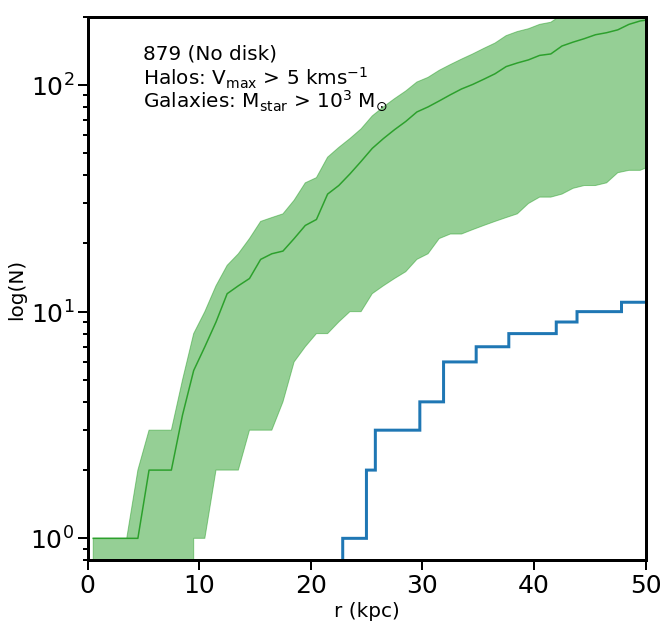

988
152.162292
110190 8291


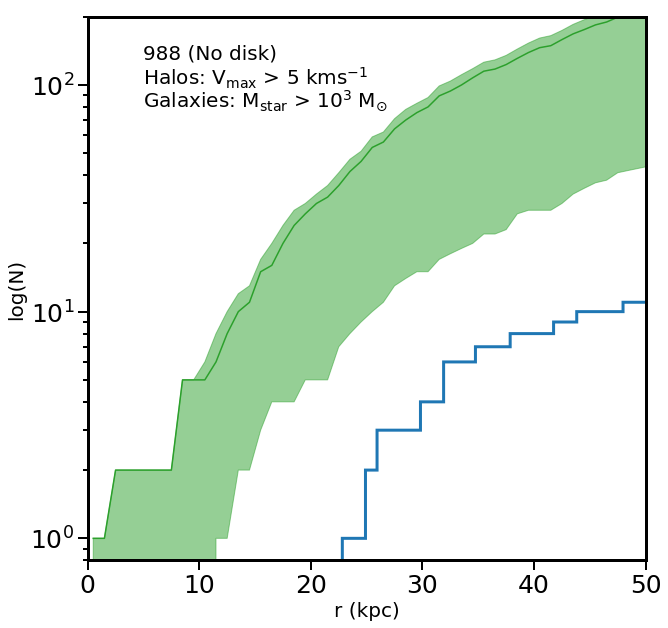

In [115]:
#Here I'm going to put Claire's module

pnts = 100

DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

DES_cone_size = 0.7259
SDSS_coneS_size = 0.7259  #t2
SDSS_coneB_size = 0.9929   #t3

#corr_factors = np.zeros((len(data_files),pnts))
#count_mas = np.zeros((len(data_files),pnts))

radius_bins = np.linspace(0.0,0.1,101)

def cart2sph(x,y,z):
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def calc_open_angle(phi_x,the_x,phi_t,the_t):
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr):
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    RO2 = 0.0
    

    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    pair_dist = z0_cens[Andr] - z0_cens[MW]   # First two are the hosts (M31 & MW)
    coord_dist = z0_cens[2:] - z0_cens[MW]
    
    dis_g = np.linalg.norm(pair_dist)
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[newaxis]
    
    angle_BG = np.arctan(RO2/dis_g)
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])
    _, phi_t, the_t = cart2sph(-pair_dist[0],-pair_dist[1],-pair_dist[2])

    ang_dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    Andr_gal = ang_dis <= angle_BG # Mask things that are in the same area as Andr.
    Andr_gal = Andr_gal[np.newaxis].T & np.ones(pnts,dtype = 'bool') # Make into N x pnts matrix

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts)) & (~Andr_gal)

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS

    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    for ii in range(len(stacked_distance_array_fast[0])):
        #pull out each individual mask
        indiv_mask = in_cones[:,ii]
        #pull out each of the distance arrays (note: I could just use the distances as in always using the
        #distances_from_center array, but I matricized it in case I ever figure out how to do this without
        #a loop)
        indiv_dist = stacked_distance_array_fast[:,ii]
        
        halos_within_cone = indiv_dist[indiv_mask]
        
        #now lets bin it with a histogram
        
        hist, bins = np.histogram(halos_within_cone,bins=radius_bins)
        histogram_matrix[ii] = np.cumsum(hist)
    
    #print len(masking_test)
    #print len(stacked_distance_array_fast[:,0][in_cones[:,0]])
    
    count_mas = np.sum(in_cones[Data_M[2:] >= M_t], axis = 0 ) * 1.
    count_tot = np.sum(r_msk[Data_M[2:] >= M_t], axis = 0 ) * 1.
    
    #print shape(in_cones)
    #print shape(stacked_distance_array_fast)
    #print shape(distances_within_cones)
    
    return histogram_matrix

'''for file_name in xrange(len(data_files)):
    # file.write(" NEW " + file_name+' ')
    if use_vmax:
        Data_M = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt')[:,0]
    else:
        Data_M = np.amax(np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt'),axis=1)
    Data_X = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/X.txt')[:,0]
    Data_Y = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Y.txt')[:,0]
    Data_Z = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Z.txt')[:,0]
    Data_Rvir = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Rvir.txt')[:,0]

    corr_factors[file_name],count_mas[file_name] = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)
'''

for data_file in os.listdir('./Tyler_Data/'):
    f_halos = h5py.File('./Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 5.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    print Data_M_cut[host_index]
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index
    
    print len(Data_X), len(Data_X_cut) 

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.median(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    
    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]
    
    #print hl_line[0]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e3)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')

    plt.text(5.0,130.0,halo_name+' (No disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 5 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^3$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.legend(loc=1, prop={'size': 20})
    plt.savefig('./initial_figures/non_disk_'+str(halo_name)+'_small.png',bbox_inches='tight')
    plt.show()

178.599808
238367 3795
what
448


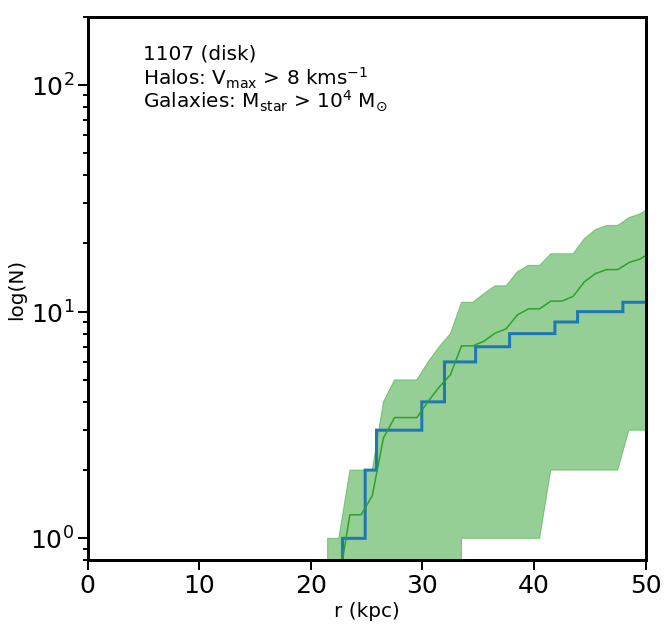

172.927429
101216 1653
what
580


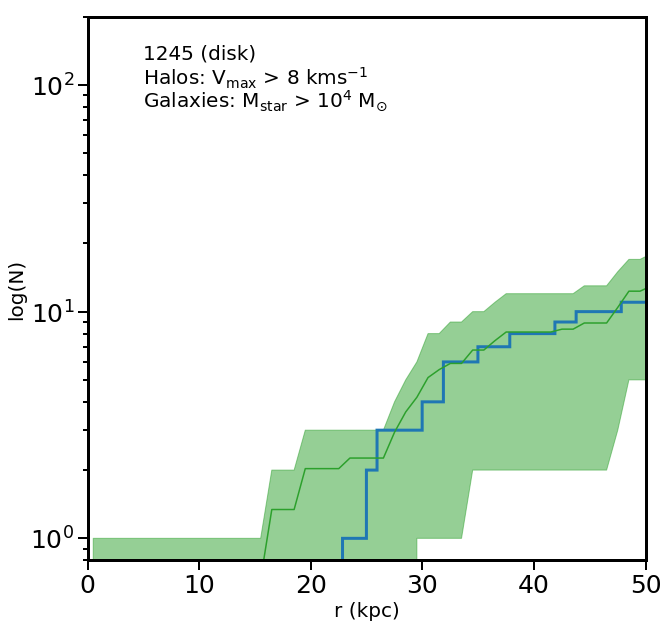

163.505722
115092 1697
what
1190


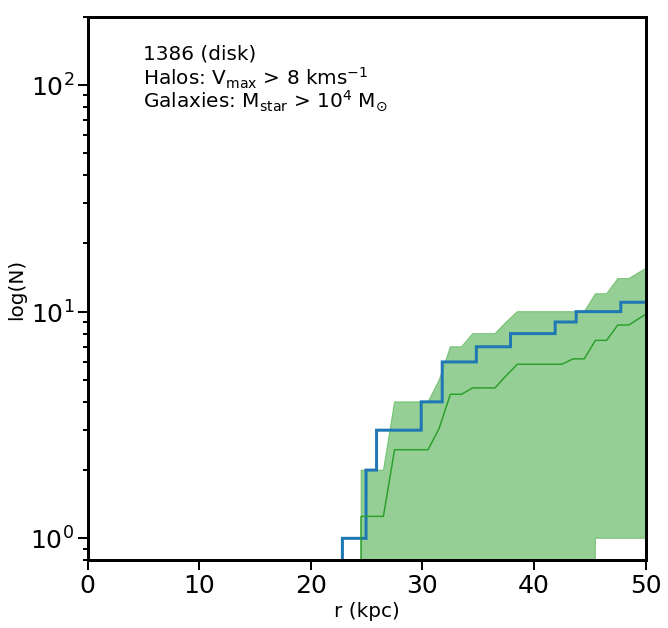

202.228943
179809 2921
what
2094


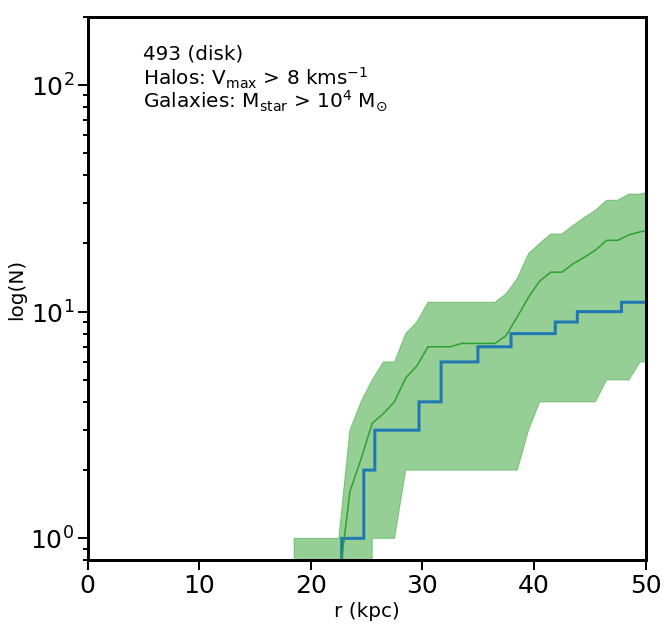

205.71376
171282 2656
what
518


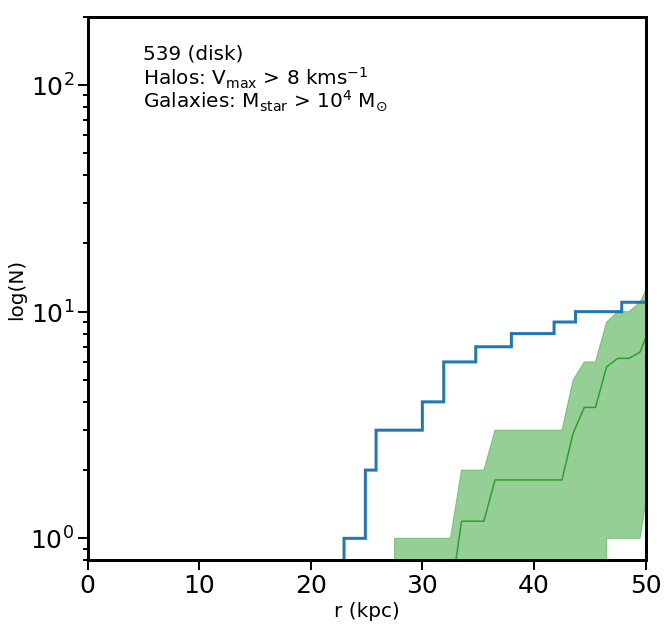

195.583115
194802 3016
what
2278


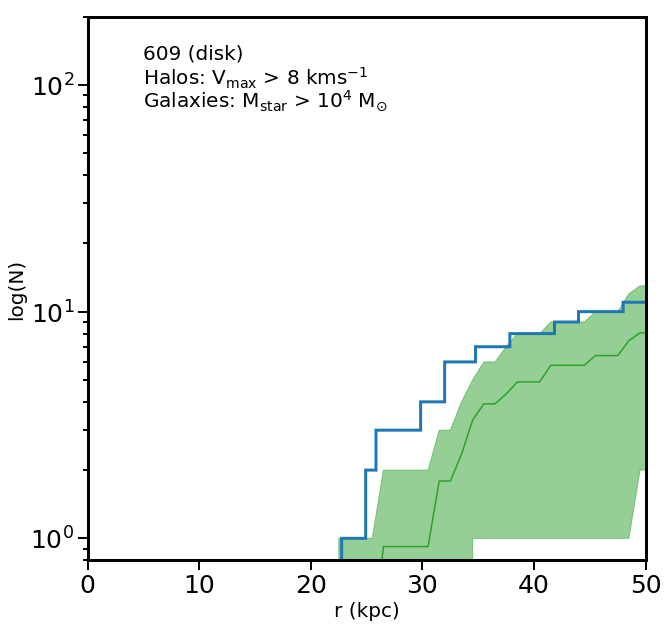

189.467468
229949 3519
what
2587


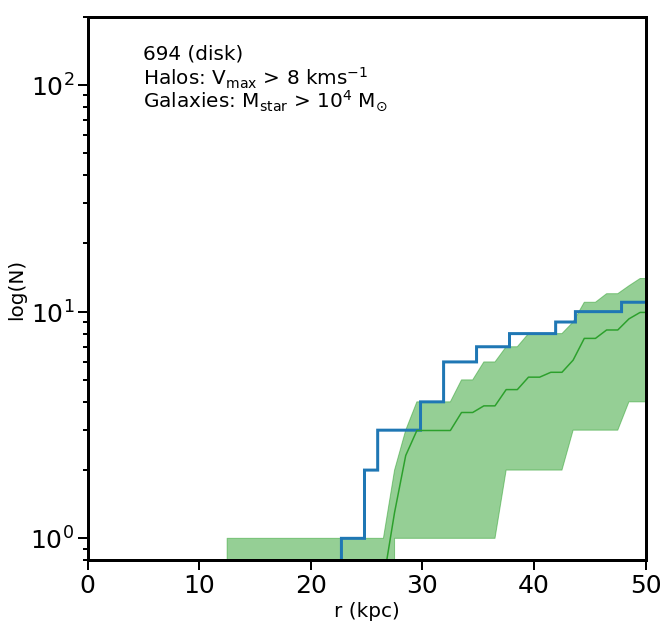

187.713303
154345 2399
what
2054


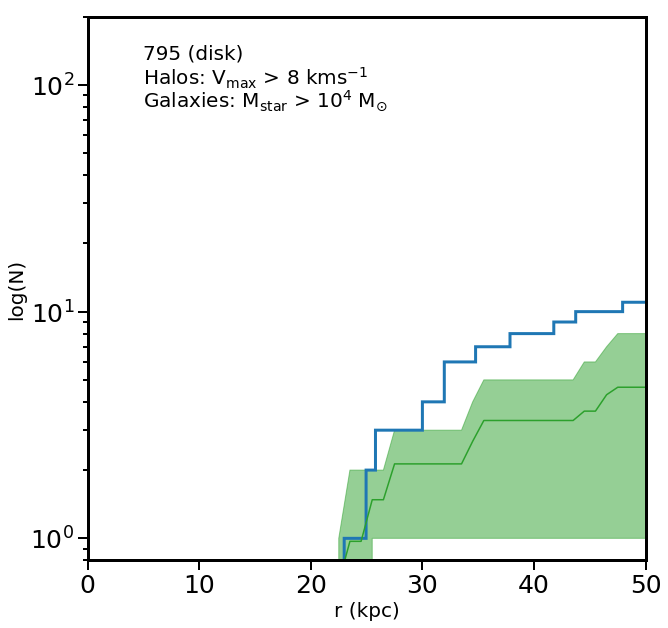

165.507858
160314 2632
what
151


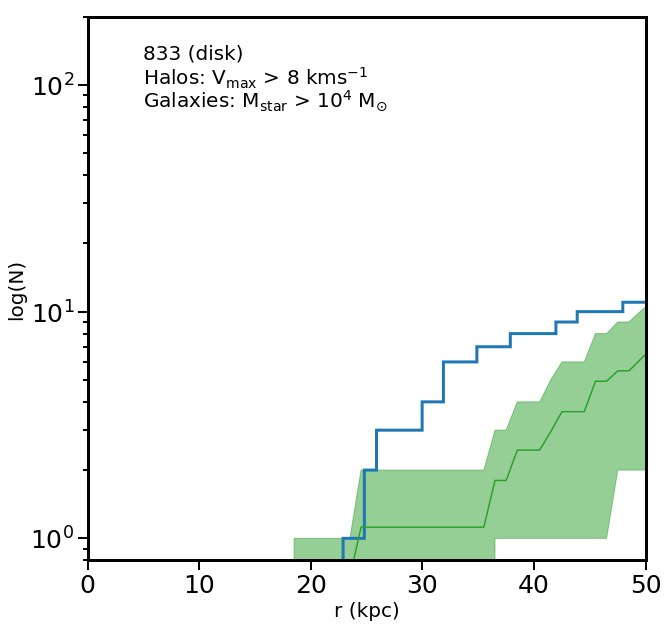

202.330902
128496 1913
what
385


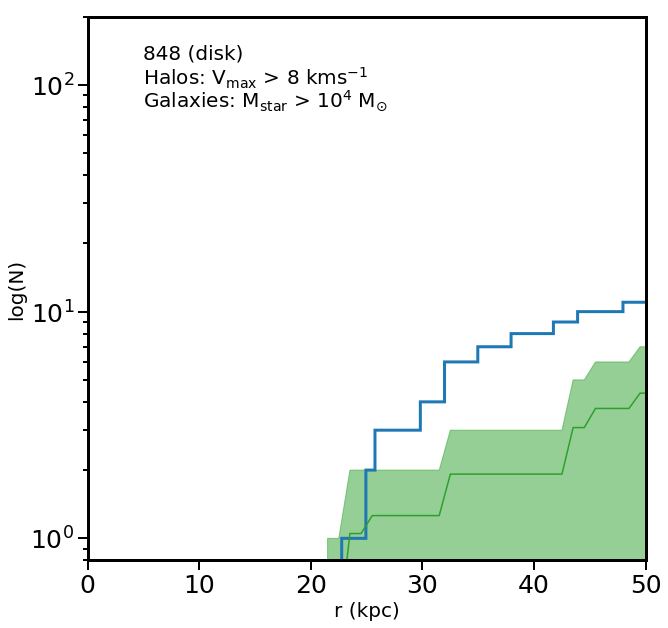

180.47937
134773 1918
what
1234


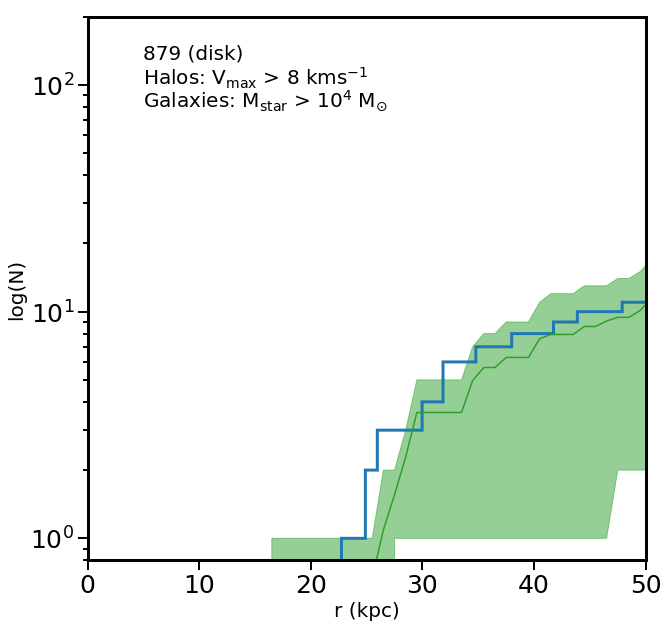

171.383865
106007 1658
what
89


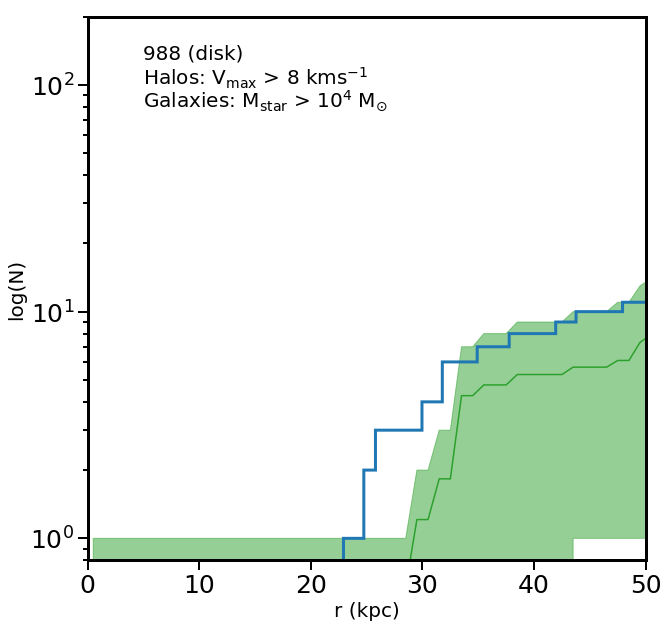

In [119]:
#Here I'm going to put Claire's module

pnts = 100

DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

DES_cone_size = 0.7259
SDSS_coneS_size = 0.7259  #t2
SDSS_coneB_size = 0.9929   #t3

#corr_factors = np.zeros((len(data_files),pnts))
#count_mas = np.zeros((len(data_files),pnts))

radius_bins = np.linspace(0.0,0.1,101)

h = 0.6751

def cart2sph(x,y,z):
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def calc_open_angle(phi_x,the_x,phi_t,the_t):
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr):
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    RO2 = 0.0
    

    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    print 'what'
    print MW
    pair_dist = z0_cens[Andr] - z0_cens[MW]   # First two are the hosts (M31 & MW)
    coord_dist = z0_cens[2:] - z0_cens[MW]
    
    dis_g = np.linalg.norm(pair_dist)
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[newaxis]
    
    angle_BG = np.arctan(RO2/dis_g)
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])
    _, phi_t, the_t = cart2sph(-pair_dist[0],-pair_dist[1],-pair_dist[2])

    ang_dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    Andr_gal = ang_dis <= angle_BG # Mask things that are in the same area as Andr.
    Andr_gal = Andr_gal[np.newaxis].T & np.ones(pnts,dtype = 'bool') # Make into N x pnts matrix

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts)) & (~Andr_gal)

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS

    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    for ii in range(len(stacked_distance_array_fast[0])):
        #pull out each individual mask
        indiv_mask = in_cones[:,ii]
        #pull out each of the distance arrays (note: I could just use the distances as in always using the
        #distances_from_center array, but I matricized it in case I ever figure out how to do this without
        #a loop)
        indiv_dist = stacked_distance_array_fast[:,ii]
        
        halos_with_host = indiv_dist[indiv_mask]
        no_host_mask = (halos_with_host!=0.0)
        halos_within_cone = halos_with_host[no_host_mask]
        #now lets bin it with a histogram
        
        hist, bins = np.histogram(halos_within_cone,bins=radius_bins)
        histogram_matrix[ii] = np.cumsum(hist)
    
    #print len(masking_test)
    #print len(stacked_distance_array_fast[:,0][in_cones[:,0]])
    
    count_mas = np.sum(in_cones[Data_M[2:] >= M_t], axis = 0 ) * 1.
    count_tot = np.sum(r_msk[Data_M[2:] >= M_t], axis = 0 ) * 1.
    
    #print shape(in_cones)
    #print shape(stacked_distance_array_fast)
    #print shape(distances_within_cones)
    
    return histogram_matrix

'''for file_name in xrange(len(data_files)):
    # file.write(" NEW " + file_name+' ')
    if use_vmax:
        Data_M = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt')[:,0]
    else:
        Data_M = np.amax(np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt'),axis=1)
    Data_X = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/X.txt')[:,0]
    Data_Y = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Y.txt')[:,0]
    Data_Z = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Z.txt')[:,0]
    Data_Rvir = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Rvir.txt')[:,0]

    corr_factors[file_name],count_mas[file_name] = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)
'''

for data_file in os.listdir('./Tyler_disk_data/'):
    f_halos = np.loadtxt('./Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    print Data_M_cut[host_index]
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index
    
    print len(Data_X), len(Data_X_cut) 

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.mean(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    
    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')
    #plt.xscale('log')
    
    plt.text(5.0,130.0,halo_name+' (disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.legend(loc=1, prop={'size': 20})
    #plt.savefig('./figures_from_notebooks/normalized_grad_50.png',bbox_inches='tight')
    plt.savefig('./initial_figures/disk_'+str(halo_name)+'.png',bbox_inches='tight')
    plt.show()

178.599808
238367 16957


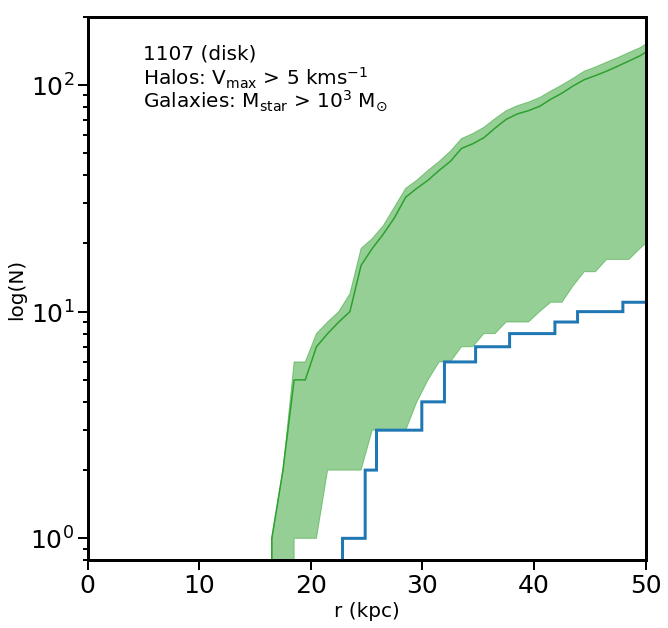

172.927429
101216 7867


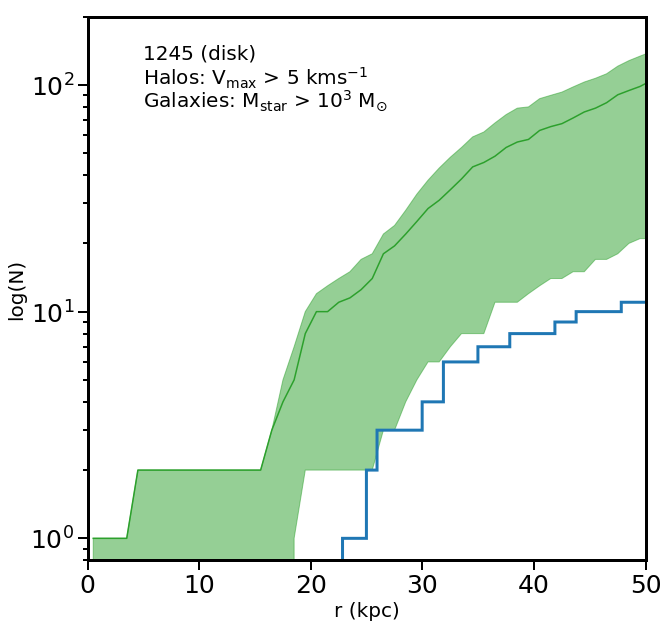

163.505722
115092 8012


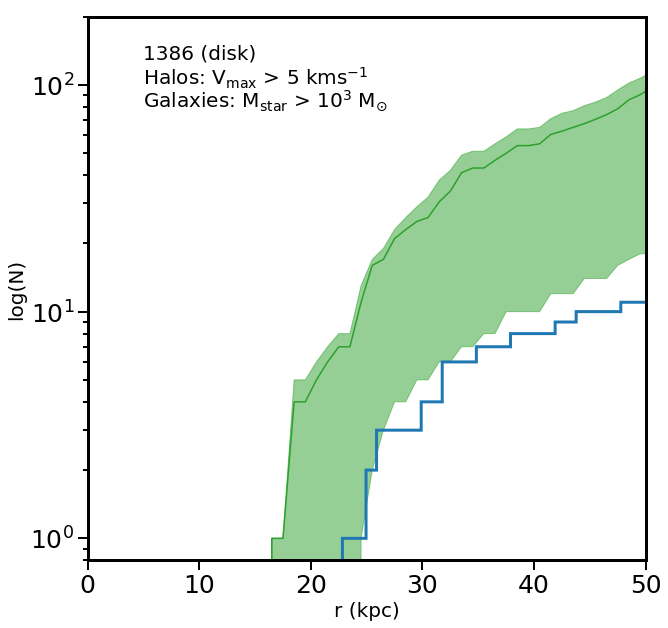

202.228943
179809 14521


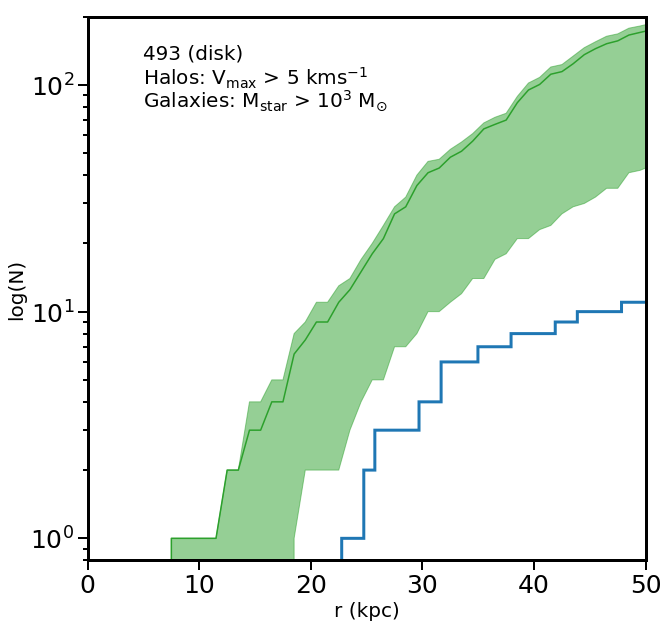

205.71376
171282 12336


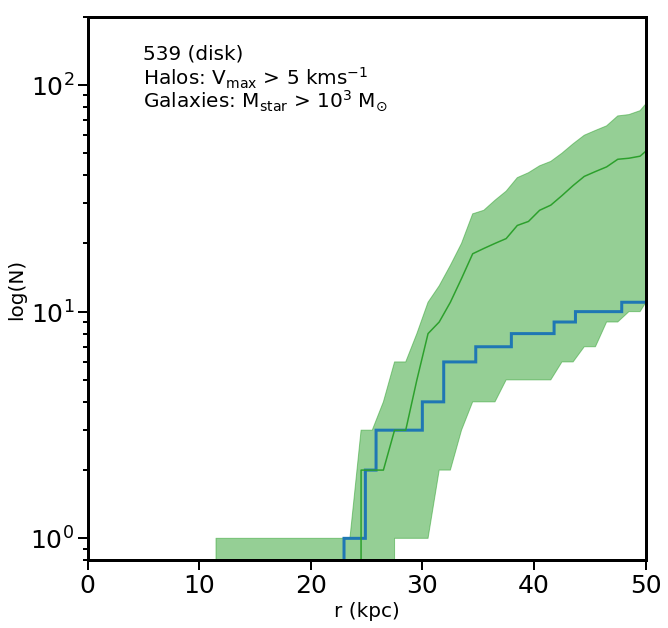

195.583115
194802 14143


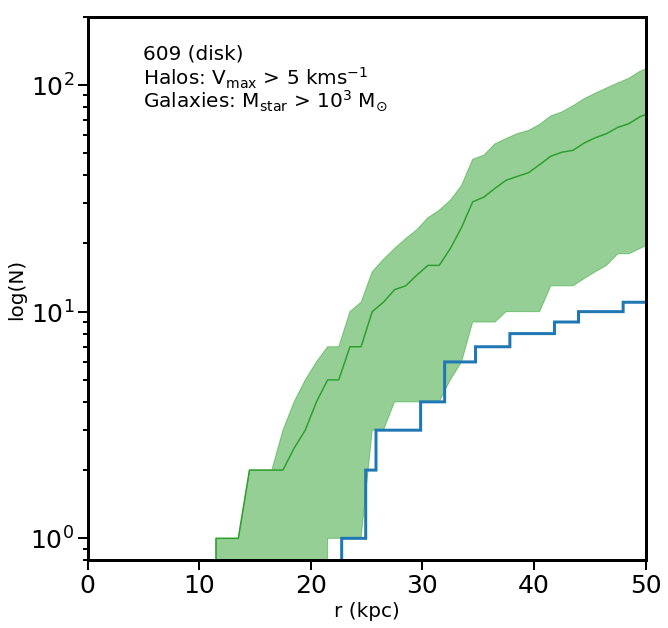

189.467468
229949 15632


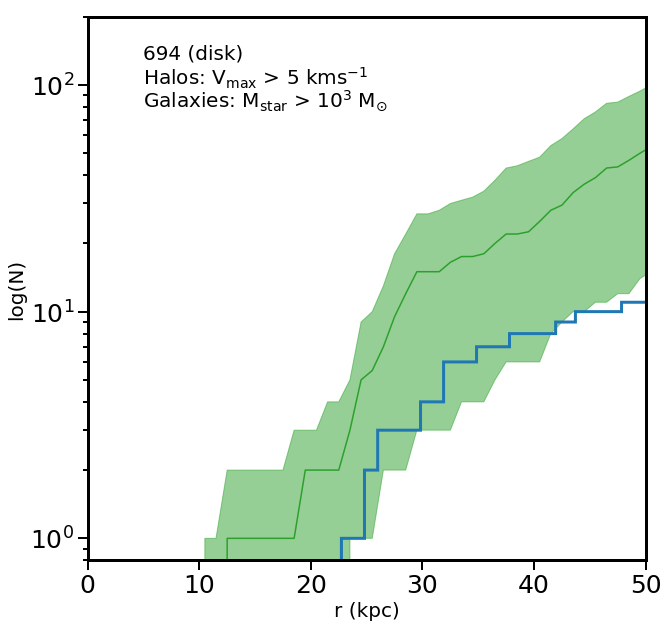

187.713303
154345 11678


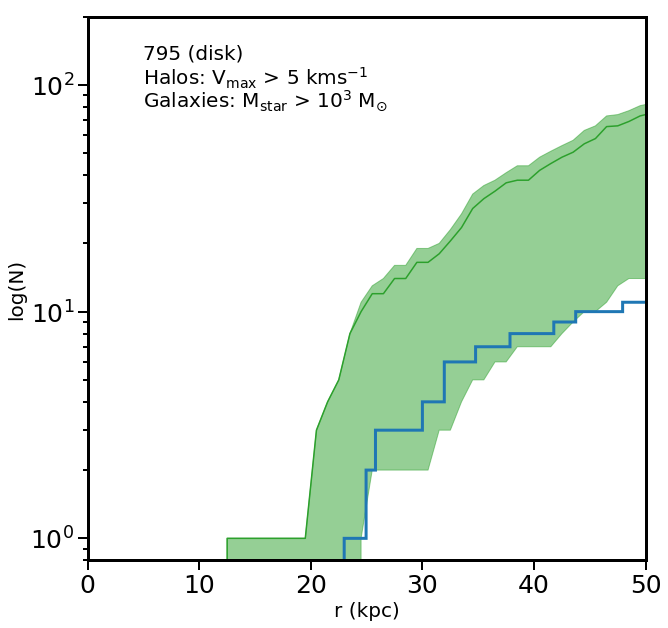

165.507858
160314 11813


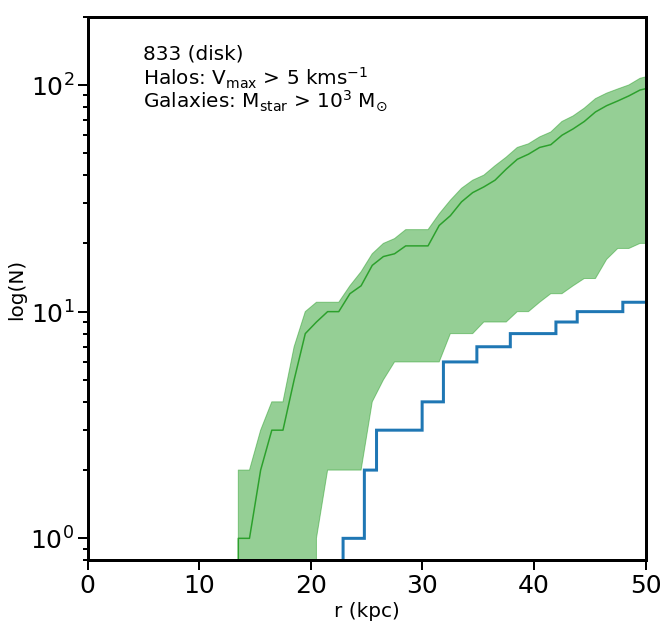

202.330902
128496 9295


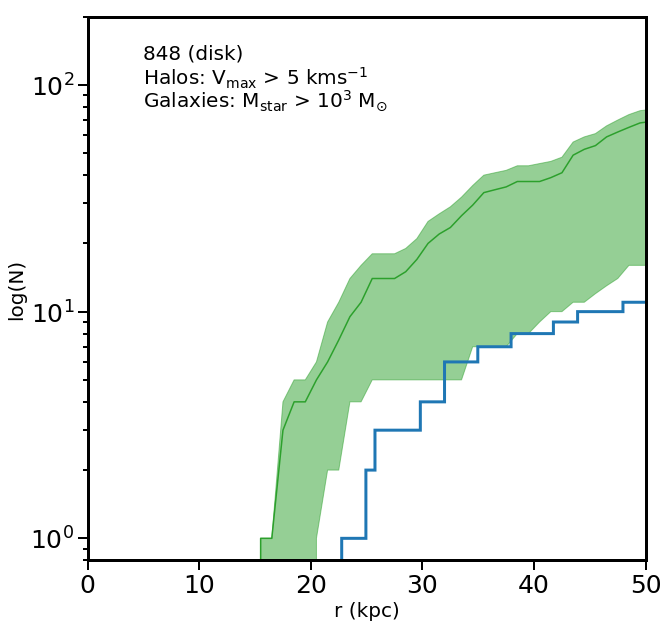

180.47937
134773 9326


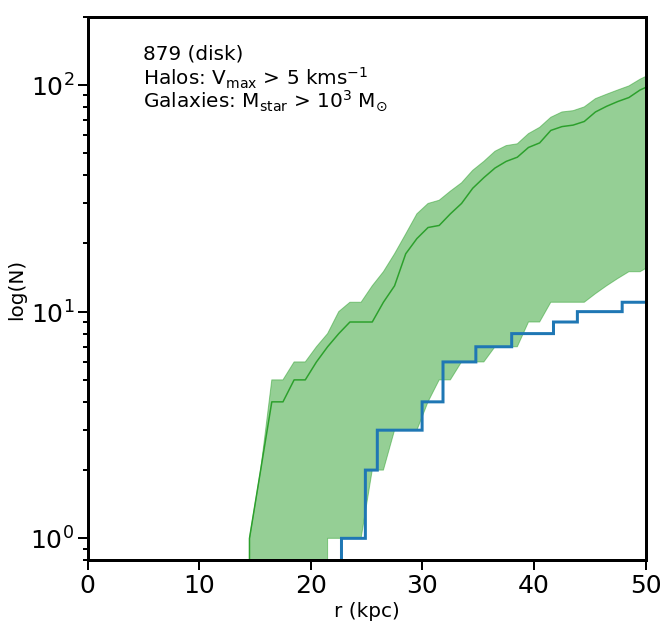

171.383865
106007 7879


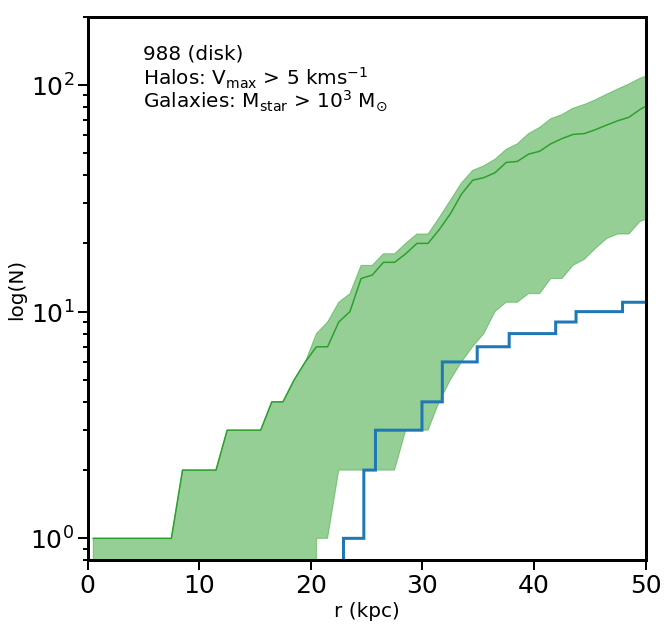

In [121]:
#Here I'm going to put Claire's module

pnts = 100

DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

DES_cone_size = 0.7259
SDSS_coneS_size = 0.7259  #t2
SDSS_coneB_size = 0.9929   #t3

#corr_factors = np.zeros((len(data_files),pnts))
#count_mas = np.zeros((len(data_files),pnts))

radius_bins = np.linspace(0.0,0.1,101)

def cart2sph(x,y,z):
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def calc_open_angle(phi_x,the_x,phi_t,the_t):
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr):
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    RO2 = 0.0
    

    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    pair_dist = z0_cens[Andr] - z0_cens[MW]   # First two are the hosts (M31 & MW)
    coord_dist = z0_cens[2:] - z0_cens[MW]
    
    dis_g = np.linalg.norm(pair_dist)
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[newaxis]
    
    angle_BG = np.arctan(RO2/dis_g)
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])
    _, phi_t, the_t = cart2sph(-pair_dist[0],-pair_dist[1],-pair_dist[2])

    ang_dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    Andr_gal = ang_dis <= angle_BG # Mask things that are in the same area as Andr.
    Andr_gal = Andr_gal[np.newaxis].T & np.ones(pnts,dtype = 'bool') # Make into N x pnts matrix

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts)) & (~Andr_gal)

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS

    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    for ii in range(len(stacked_distance_array_fast[0])):
        #pull out each individual mask
        indiv_mask = in_cones[:,ii]
        #pull out each of the distance arrays (note: I could just use the distances as in always using the
        #distances_from_center array, but I matricized it in case I ever figure out how to do this without
        #a loop)
        indiv_dist = stacked_distance_array_fast[:,ii]
        
        halos_with_host = indiv_dist[indiv_mask]
        no_host_mask = (halos_with_host!=0.0)
        halos_within_cone = halos_with_host[no_host_mask]
        
        #now lets bin it with a histogram
        
        hist, bins = np.histogram(halos_within_cone,bins=radius_bins)
        histogram_matrix[ii] = np.cumsum(hist)
    
    #print len(masking_test)
    #print len(stacked_distance_array_fast[:,0][in_cones[:,0]])
    
    count_mas = np.sum(in_cones[Data_M[2:] >= M_t], axis = 0 ) * 1.
    count_tot = np.sum(r_msk[Data_M[2:] >= M_t], axis = 0 ) * 1.
    
    #print shape(in_cones)
    #print shape(stacked_distance_array_fast)
    #print shape(distances_within_cones)
    
    return histogram_matrix

'''for file_name in xrange(len(data_files)):
    # file.write(" NEW " + file_name+' ')
    if use_vmax:
        Data_M = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt')[:,0]
    else:
        Data_M = np.amax(np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Vmax.txt'),axis=1)
    Data_X = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/X.txt')[:,0]
    Data_Y = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Y.txt')[:,0]
    Data_Z = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Z.txt')[:,0]
    Data_Rvir = np.loadtxt('../ELVIS/PairedTrees/'+data_files[file_name]+'/Rvir.txt')[:,0]

    corr_factors[file_name],count_mas[file_name] = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)
'''

for data_file in os.listdir('./Tyler_disk_data/'):
    f_halos = np.loadtxt('./Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 5.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    print Data_M_cut[host_index]
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index
    
    print len(Data_X), len(Data_X_cut) 

    hist_matrix = calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, pnts, MW, Andr)
    
    #hist_matrix = calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, pnts, MW, Andr)

    plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

    min_line = [np.min(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    max_line = [np.max(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    med_line = [np.median(hist_matrix[:,ii]) for ii in range(len(hist_matrix[0]))]
    
    hl_line = [high_low_limit(hist_matrix[:,ii],0.68) for ii in range(len(hist_matrix[0]))]
    
    low_line = [xx[0] for xx in hl_line]
    high_line = [xx[1] for xx in hl_line]

    plot_top = max_line[-1]
    
    #print distances_within_cones[:,0], stacked_distance_array_fast[:,0]

    f_dat = np.loadtxt('../Sats_data.csv',delimiter=',',dtype=object)
    gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
    gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

    large_gal_mask = (gal_mass>1.0e3)&(gal_dist<R_vir_host)

    large_gal_dist = gal_dist[large_gal_mask]
    #print large_gal_dist

    plt.figure(1,(10,10))
    rc('axes',linewidth=3)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.tick_params(which='minor',width=2,length=5)
    plt.tick_params(which='major',width=2,length=10)
    plt.xlim([0.0,50.0])
    plt.ylim([0.8,200.0])
    plt.xlabel('r (kpc)',fontsize=20)
    plt.ylabel('log(N)',fontsize=20)
    plt.yscale('log')
    
    plt.text(5.0,130.0,halo_name+' (disk)',fontsize=20)
    plt.text(5.0,100.0,'Halos: $V_{max}$ > 5 $kms^{-1}$',fontsize=20)
    plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^3$ $M_{\odot}$',fontsize=20)
    
    plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3)

    plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5)
    plt.plot(plot_bins,med_line,color='C2')

    #plt.yscale('log')
    #plt.legend(loc=1, prop={'size': 20})
    #plt.savefig('./figures_from_notebooks/normalized_grad_50.png',bbox_inches='tight')
    plt.savefig('./initial_figures/disk_'+str(halo_name)+'_small.png',bbox_inches='tight')
    plt.show()

In [61]:
print re.split('_|\.',str(data_file))

['reduced', 'data', '1107', 'txt']
